In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [9, 6]

import sys
sys.path.append("../derrom/")

import derrom

In [3]:
trajectories = derrom.utils.load_trajectories(filename='../../trajectories_n_kmax=200.npz')

trajectories = trajectories[::10]

n_trajectories = len(trajectories)
n_kmax = trajectories[0].shape[1]

print(n_trajectories, 'loaded with n_kmax =', n_kmax)

100 loaded with n_kmax = 200


runs[0] shape:  (400, 200)


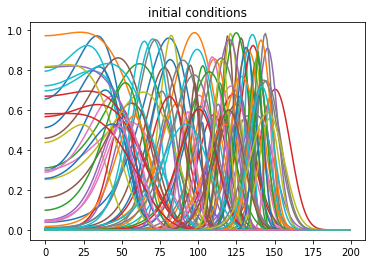

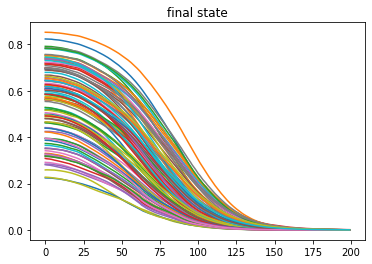

In [4]:
print('runs[0] shape: ', trajectories[0].shape)

for k in range(n_trajectories):
    plt.plot(trajectories[k][0])

plt.title('initial conditions')
plt.show()


for k in range(n_trajectories):
    plt.plot(trajectories[k][-1])

plt.title('final state')
plt.show()

In [8]:
sys.path.append("../experimental/")

import optimizers as eoptimizers


optimizer = narrom.optimizer.PIML_adam(dim_reducer=dim_reducer, alpha=10.**-3.5, lambda1=1e7, mini_batch_size=390000, epochs = 100)

dim_reducer = derrom.dim_reducers.SVD()
# dim_reducer = derrom.dim_reducers.DFT(sorted=True)
# dim_reducer = derrom.dim_reducers.Hermite(sample_max = 1.0, sorted=True, optimize=True, orthogonalize=True, train_rdim=20)

# scaler = derrom.scalers.normalize_scaler(0.1)
scaler = derrom.scalers.standardize_scaler(1.0)
# scaler = derrom.scalers.tanh_scaler(0.1)

# transformer = derrom.transformers.polynomial_features(order=2)
transformer = derrom.transformers.ELM_features(ELM_nodes=400)

# optimizer = derrom.optimizers.ridge(alpha=10.**-3)
# optimizer = derrom.optimizers.lstsqrs()
optimizer = eoptimizers.PIML_adam(dim_reducer=dim_reducer,
                                  alpha=10.**-3.5, 
                                  lambda1=1e7, 
                                  mini_batch_size=39000, 
                                  epochs = 100)

model = derrom.derrom(trajectories, targets='AR', DE_l=2, intercept=True, full_hist=False,
                    optimizer=optimizer,
                    scaler=scaler,
                    dim_reducer=dim_reducer,
                    NL_transformer=transformer)

model.train(rdim=15)

model.print_status()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/meinecke/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3369, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_347415/1422899058.py", line 3, in <cell line: 3>
    import optimizers as eoptimizers
  File "../experimental/optimizers.py", line 26, in <module>
    import ELPH_dyn
ModuleNotFoundError: No module named 'ELPH_dyn'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/meinecke/.local/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 1982, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/meinecke/.local/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1118, in structured_traceback
    return FormattedTB.structured_traceback(
  File "/home/meinecke/.local/lib/python3.9/site-packages/IPython/core/ultratb.py", line 1012, in structured_traceba

In [51]:

test_trajectory = narrom.utils.load_trajectories(filename='/home/agluedge/Preprints/ELPH/example_run.npz')[0].T
print('example trajectory loaded with shape: ', test_trajectory.shape)


example trajectory loaded with shape:  (400, 200)


In [17]:
test_trajectory = trajectories[17]

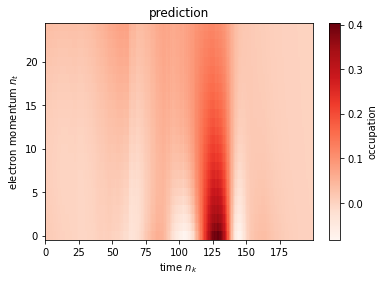

In [44]:
pred = model.predict(test_trajectory[:1],25)

narrom.utils.plot_trajectory(pred,'prediction')

In [57]:
pred = model.predict_test_trajectory(test_trajectory)

print('std error: ', model.get_error(test_trajectory, pred, norm='NF') )
print('max error: ', model.get_error(test_trajectory, pred, norm='max') )

std error:  0.0052927516724322835
max error:  0.15175797144557102


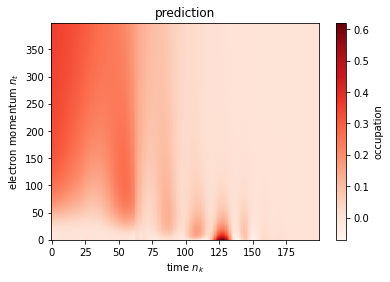

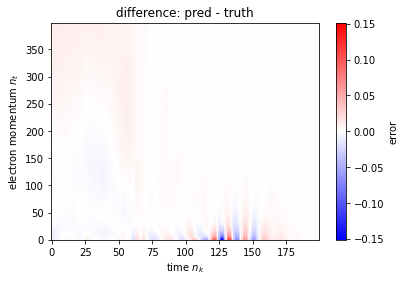

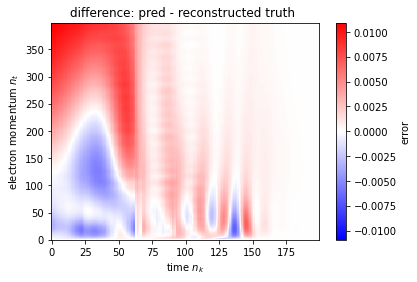

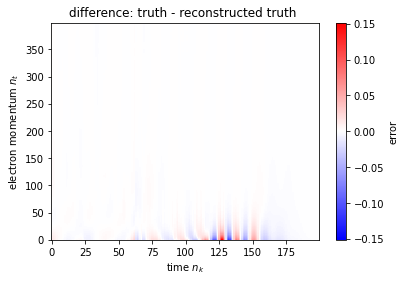

In [58]:

narrom.utils.plot_trajectory(pred, 'prediction')

narrom.utils.plot_difference(pred,test_trajectory,'difference: pred - truth')


test_trajectory_SVDapprx = dim_reducer.reconstruct( dim_reducer.reduce(test_trajectory,15) )

narrom.utils.plot_difference(pred,test_trajectory_SVDapprx,'difference: pred - reconstructed truth ')

narrom.utils.plot_difference(test_trajectory,test_trajectory_SVDapprx,'difference: truth - reconstructed truth ')


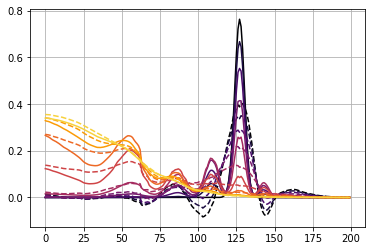

NF error:  0.019642133498478948
max abs error:  0.3756102655538183


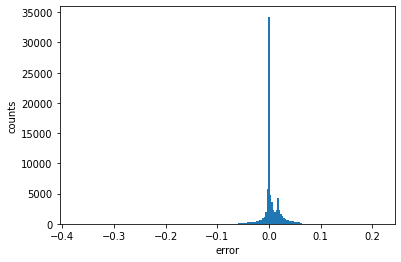

In [47]:
pl_colors = plt.get_cmap('inferno')

tn_arr = [0,2,5,10,20,50,100,200,399]

plt.grid()

for k,tn in enumerate(tn_arr):
    plt.plot(test_trajectory[tn], '-', c=pl_colors(k/len(tn_arr)))
    plt.plot(pred[tn], '--', c=pl_colors(k/len(tn_arr)))

plt.show()

print('NF error: ', model.get_error(test_trajectory, pred, norm='NF') )
print('max abs error: ', model.get_error(test_trajectory, pred, norm='max') )

plt.hist(np.ravel(pred-test_trajectory), bins = 200)
plt.xlabel('error')
plt.ylabel('counts')
plt.show()

In [6]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.normalize_scaler(0.1)
transformer = narrom.transformer.polynomial_features(order=2)
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)

model = narrom.narrom(trajectories, VAR_l=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

train_kwargs = {'rdim':20, 'prdim':20}

scores = narrom.utils.get_KFold_CV_scores(model, trajectories, folds=10, seed=817, norms=['NF','max'], train_kwargs=train_kwargs)

print('NF error: ', str(np.mean(scores[0])) + ' +- ' + str(np.std(scores[0])) )
print('max error: ', str(np.mean(scores[1])) + ' +- ' + str(np.std(scores[1])) )

NF error:  0.006301407495053643 +- 0.00393118079468427
max error:  0.03138361624470426 +- 0.022604387936276796


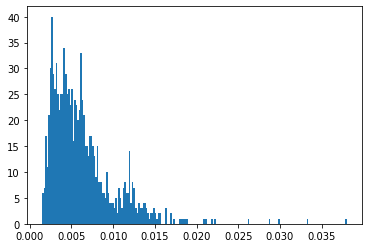

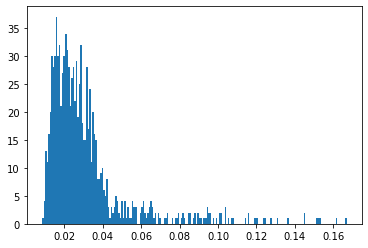

In [7]:
plt.hist(scores[0],bins=200)
plt.show()

plt.hist(scores[1],bins=200)
plt.show()

full_hist:  False
intercept:  True
standardize:  True
rdim:  20
prdim:  20
VAR_l:  2
train shape:  (399000, 861)
target shape:  (399000, 20)
weights shape:  (861, 20)
NF error:  0.007604513620717341
max error:  0.03200846913700883


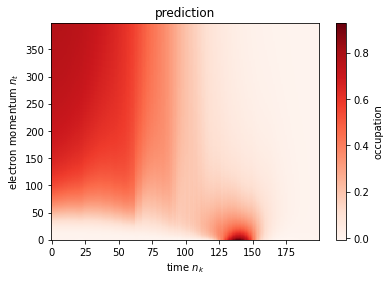

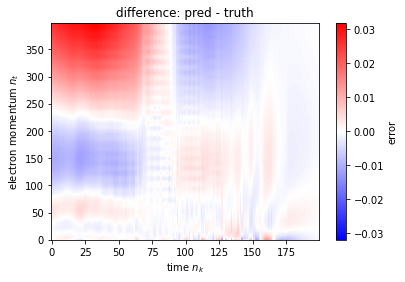

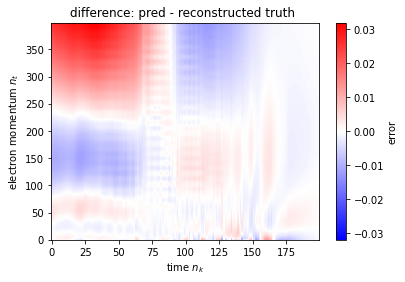

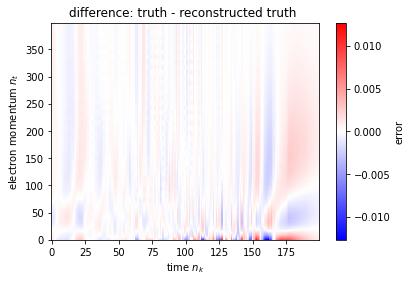

In [9]:
dim_reducer = narrom.dim_reducer.SVD()
scaler = narrom.scaler.normalize_scaler(0.1)
transformer = narrom.transformer.polynomial_features(order=2)
optimizer = narrom.optimizer.ridge(alpha=10.**-3.5)

training_trajectories = trajectories[::1]
popped_test_trajectory = training_trajectories.pop(73)


model = narrom.narrom(trajectories, VAR_l=2, intercept=True, full_hist=False, optimizer=optimizer, scaler=scaler, dim_reducer=dim_reducer, VAR_transformer=transformer)

model.train(rdim=20, prdim = 20)

model.print_status()

pred = model.predict_test_trajectory(popped_test_trajectory)

print('NF error: ', model.get_error(popped_test_trajectory, pred, norm='NF') )
print('max error: ', model.get_error(popped_test_trajectory, pred, norm='max') )




narrom.utils.plot_trajectory(pred, 'prediction')

narrom.utils.plot_difference(pred,popped_test_trajectory,'difference: pred - truth')


reconstructed_popped_test_trajectory = dim_reducer.reconstruct( dim_reducer.reduce(popped_test_trajectory,20) )

narrom.utils.plot_difference(pred,popped_test_trajectory,'difference: pred - reconstructed truth ')

narrom.utils.plot_difference(popped_test_trajectory,reconstructed_popped_test_trajectory,'difference: truth - reconstructed truth ')

